In [181]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import mannwhitneyu
from scipy import stats

# Model
from sklearn.preprocessing import OneHotEncoder, StandardScaler, QuantileTransformer, MinMaxScaler
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import GridSearchCV, train_test_split, RandomizedSearchCV, KFold, RepeatedStratifiedKFold, StratifiedKFold, cross_val_score
from xgboost import XGBRegressor
from sklearn.metrics import root_mean_squared_log_error

# hyperparameter tuning
import optuna

In [164]:
try:
    kaggle_train_file_loc = "../input/playground-series-s4e11/train.csv"
    kaggle_test_file_loc = "../input/playground-series-s4e11/test.csv"
    df = pd.read_csv(kaggle_train_file_loc, index_col=0)
    df_test = pd.read_csv(kaggle_test_file_loc, index_col=0)

except:
    github_train_file_loc = "./dataset/train.csv"
    github_test_file_loc = "./dataset/test.csv"
    df = pd.read_csv(github_train_file_loc, index_col=0)
    df_test = pd.read_csv(github_test_file_loc, index_col=0)



In [3]:
# a little bit for feature engineering to the datetime column at the start
df["Policy Start Date"] = pd.to_datetime(df["Policy Start Date"])
df["Policy Year"] = df["Policy Start Date"].dt.year
df["Policy Month"] = df["Policy Start Date"].dt.month
df["Policy Month"] = df["Policy Month"].astype("object")
df["Policy Year"] = df["Policy Year"].astype("object")

# Checking characteristics of the dataset

In [4]:
df.shape

(1200000, 22)

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1200000 entries, 0 to 1199999
Data columns (total 22 columns):
 #   Column                Non-Null Count    Dtype         
---  ------                --------------    -----         
 0   Age                   1181295 non-null  float64       
 1   Gender                1200000 non-null  object        
 2   Annual Income         1155051 non-null  float64       
 3   Marital Status        1181471 non-null  object        
 4   Number of Dependents  1090328 non-null  float64       
 5   Education Level       1200000 non-null  object        
 6   Occupation            841925 non-null   object        
 7   Health Score          1125924 non-null  float64       
 8   Location              1200000 non-null  object        
 9   Policy Type           1200000 non-null  object        
 10  Previous Claims       835971 non-null   float64       
 11  Vehicle Age           1199994 non-null  float64       
 12  Credit Score          1062118 non-null  float64

In [6]:
df.isna().sum()

Age                      18705
Gender                       0
Annual Income            44949
Marital Status           18529
Number of Dependents    109672
Education Level              0
Occupation              358075
Health Score             74076
Location                     0
Policy Type                  0
Previous Claims         364029
Vehicle Age                  6
Credit Score            137882
Insurance Duration           1
Policy Start Date            0
Customer Feedback        77824
Smoking Status               0
Exercise Frequency           0
Property Type                0
Premium Amount               0
Policy Year                  0
Policy Month                 0
dtype: int64

<Axes: xlabel='Premium Amount', ylabel='Count'>

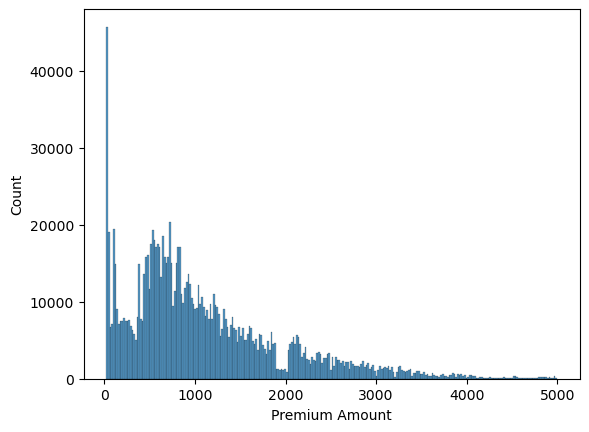

In [7]:
sns.histplot(
    data=df,
    x='Premium Amount'
)

In [8]:
df["Premium Amount"].min(), df["Premium Amount"].max()

(20.0, 4999.0)

# Exploratory Data Analysis

## Numerical Columns

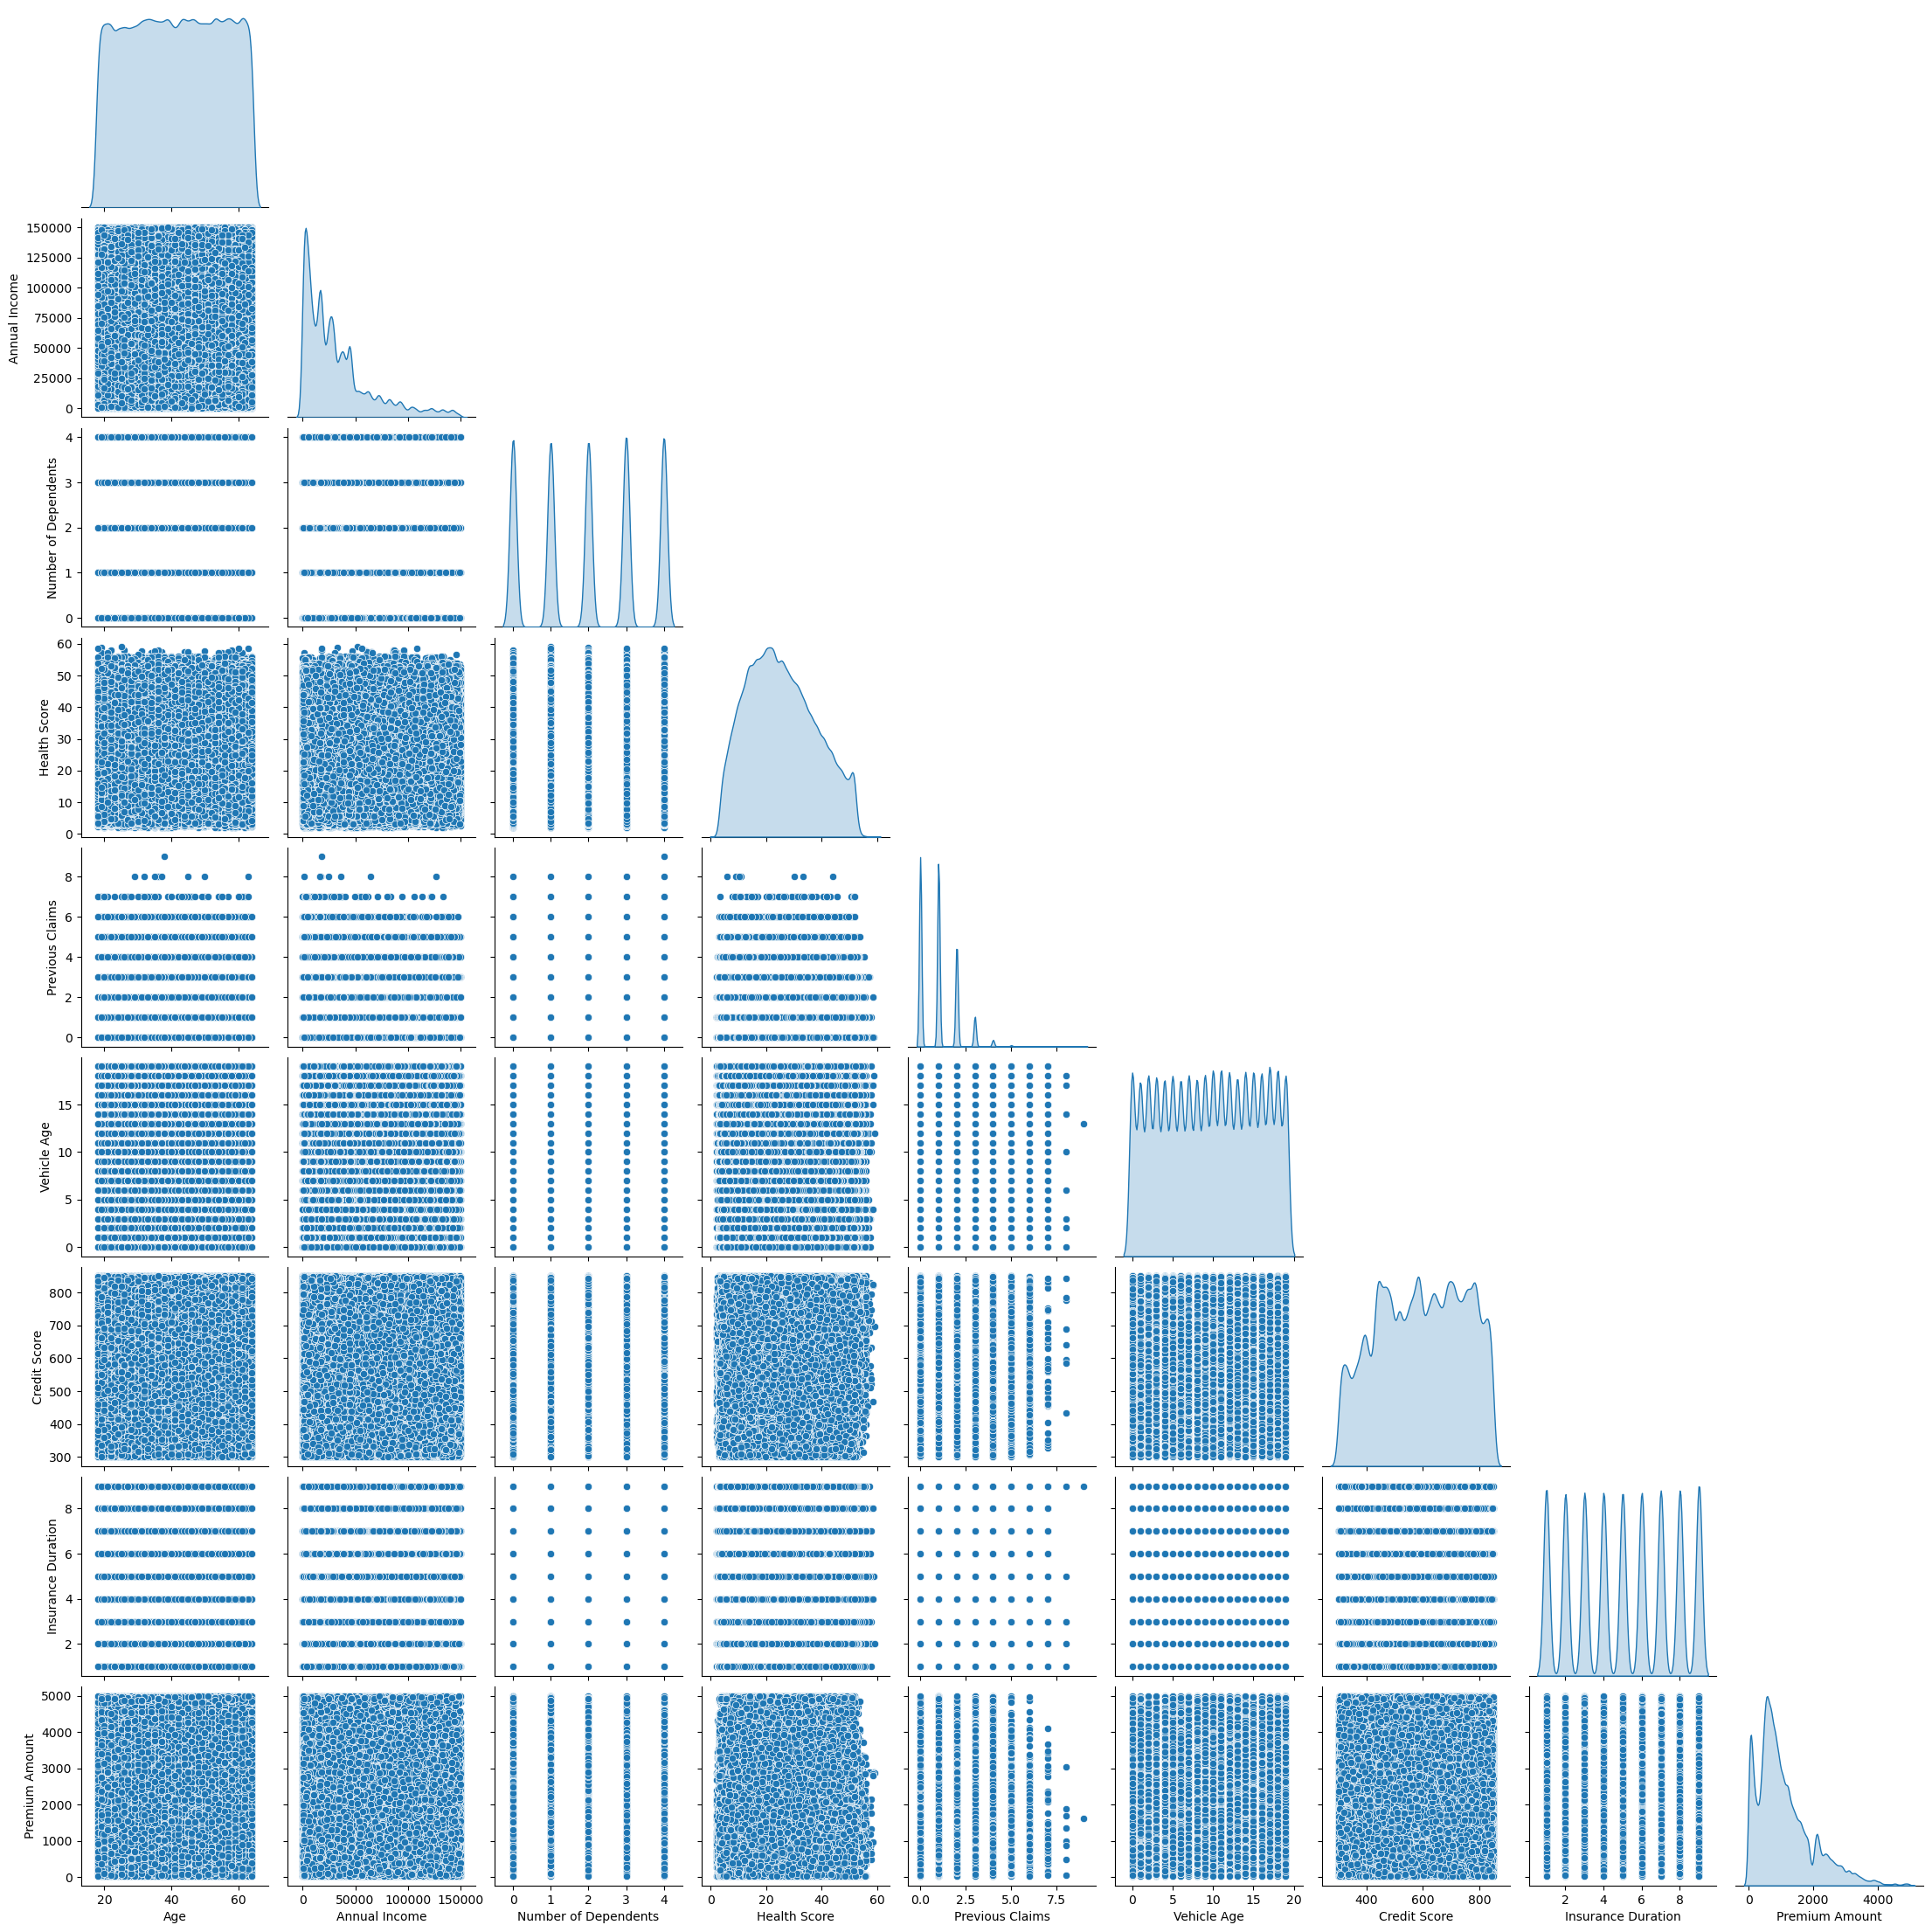

In [9]:
df_nums = df.select_dtypes(np.number)

sns.pairplot(df_nums, diag_kind="kde", corner=True)

<Axes: >

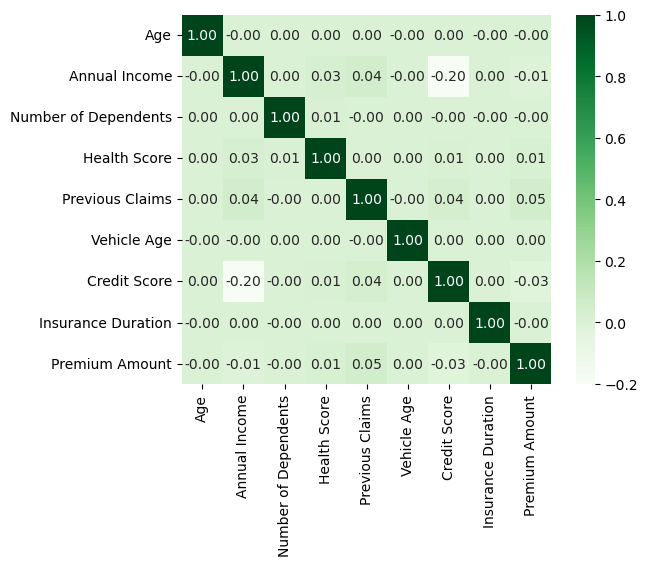

In [10]:
sns.heatmap(df_nums.corr(), cmap='Greens', annot=True, fmt='.2f', square=True)

This is a sporadic dataset. Rarely do you see almost 0 correlations across the board. Minimal correlation is also observed between the y-variable (`Premium Amount`) and X-variablaes 

In [11]:
df_nums.isna().sum()

Age                      18705
Annual Income            44949
Number of Dependents    109672
Health Score             74076
Previous Claims         364029
Vehicle Age                  6
Credit Score            137882
Insurance Duration           1
Premium Amount               0
dtype: int64

## Categorical Columns

In [12]:
df_objs = df.select_dtypes('object')
df_objs = df_objs.merge(df["Premium Amount"], left_index=True, right_index=True)

In [13]:
df_objs.isna().sum()

Gender                     0
Marital Status         18529
Education Level            0
Occupation            358075
Location                   0
Policy Type                0
Customer Feedback      77824
Smoking Status             0
Exercise Frequency         0
Property Type              0
Policy Year                0
Policy Month               0
Premium Amount             0
dtype: int64

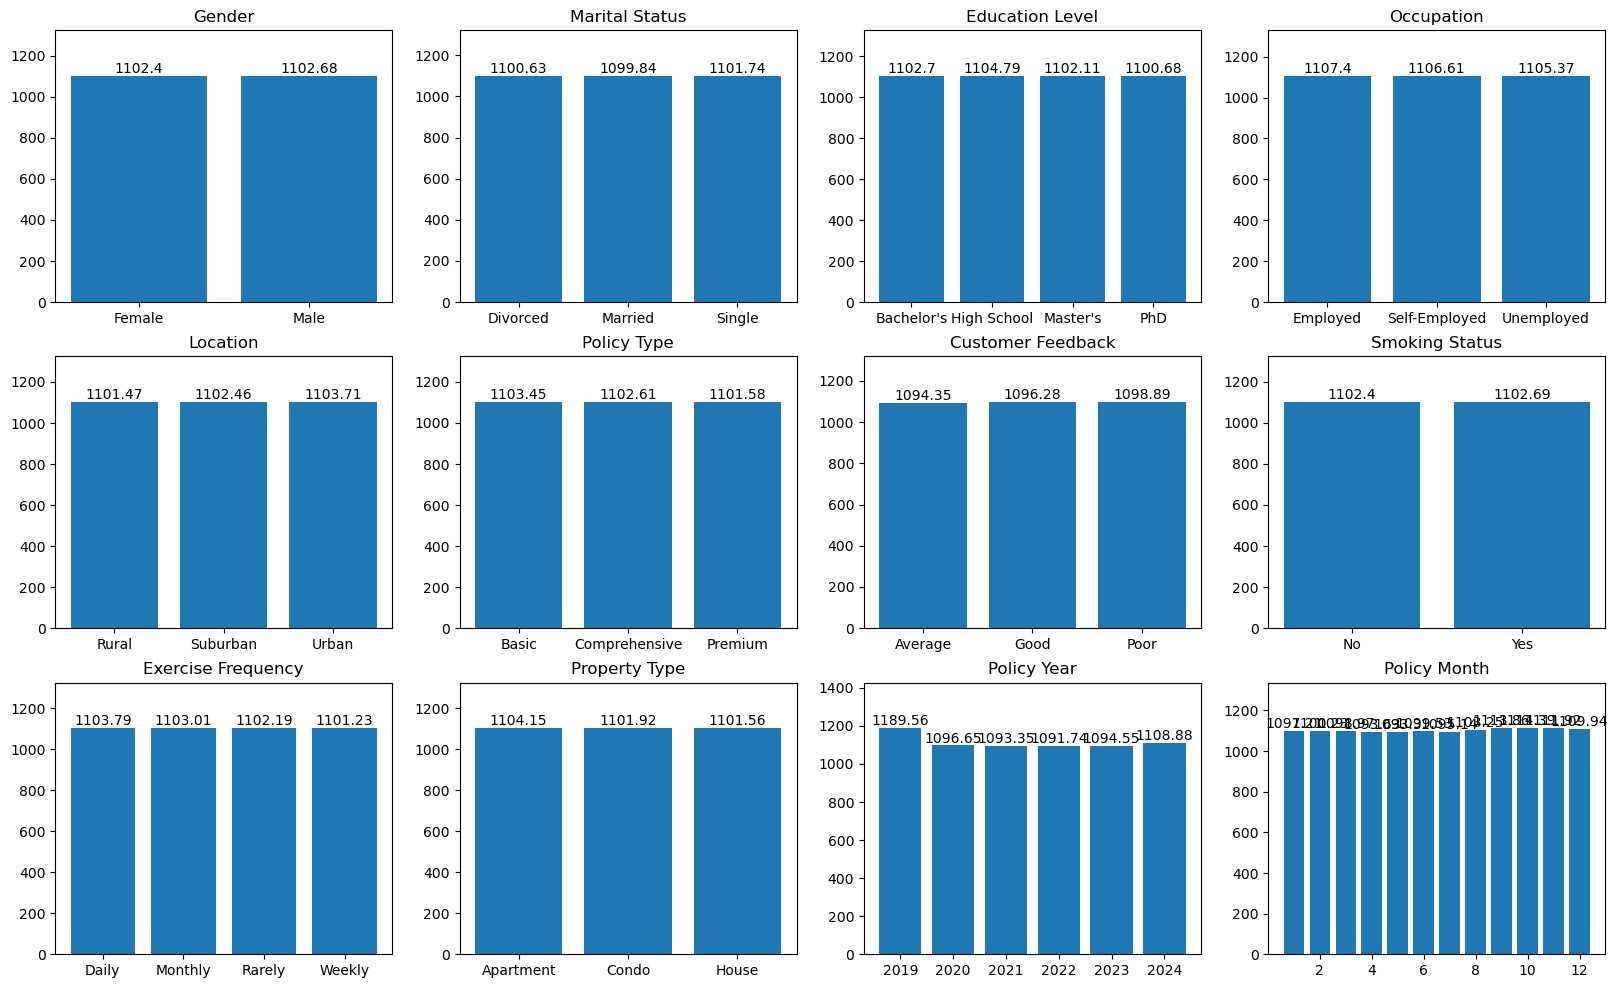

In [14]:
fig, ax = plt.subplots(3, 4, figsize=(20, 12))

for index, col_name in enumerate(df_objs.columns):
    if col_name in ['Premium Amount']:
        continue
    else:
        df_grped = df_objs.groupby(col_name)["Premium Amount"].mean()
        x = df_grped.index
        height=df_grped.values

        ax.flatten()[index].bar(x=x, height=height)
        ax.flatten()[index].bar_label(ax.flatten()[index].containers[0])
        ax.flatten()[index].set_title(col_name)
        ax.flatten()[index].set_ylim(0, height.max() * 1.2)

Observations:
1. We see that there is little differentiation in `premium amount` across all categorical variables.
2. Some inconsistencies in premium pricing was also observed. For example, there should be a marked difference in pricing for `Smoking Status` if this is a health insurance. For `Exercise Frequency`, it is odd that a __Daily__ `Exercise Frequency` is priced more than the other exercise frequencies.
3. We are also unsure about the nature of `Customer Feedback`. Does this feedback relate to the insurance purchase process, or the claiming process? Nonetheless, we observe that a __Poor__ rating, on average (both mean and median), has to pay more compared to the other two categories - again another inconsistency
4. We observe a difference in pricing across years (although not so much for months)

<Axes: xlabel='Policy Start Date', ylabel='Premium Amount'>

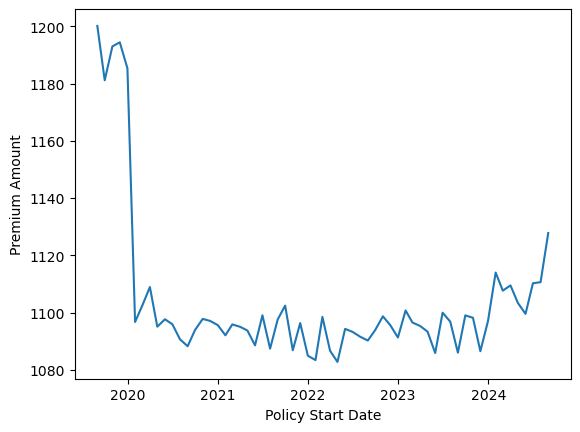

In [15]:
data_plot = df.groupby(pd.Grouper(key='Policy Start Date', freq='ME'))[["Premium Amount"]].mean()
data_plot = data_plot.reset_index()

sns.lineplot(
    data=data_plot,
    x='Policy Start Date',
    y='Premium Amount'
)

## Dealing with missing values

In [161]:
df.isna().sum()

Age                      18705
Gender                       0
Annual Income            44949
Marital Status           18529
Number of Dependents    109672
Education Level              0
Occupation              358075
Health Score             74076
Location                     0
Policy Type                  0
Previous Claims         364029
Vehicle Age                  6
Credit Score            137882
Insurance Duration           1
Policy Start Date            0
Customer Feedback        77824
Smoking Status               0
Exercise Frequency           0
Property Type                0
Premium Amount               0
dtype: int64

In [205]:
def preprocessing(df):
    result = df.copy()

    # Age: 18_705 nulls
    # convert age into bins, and then fill missing values with unknown
    intervals = pd.interval_range(start=10, end=70, freq=10)
    result["Age"] = pd.cut(result["Age"], bins=intervals, include_lowest=True).astype("object")
    result["Age"] = result["Age"].fillna("Unknown")
    # result["Age_bin"].value_counts() # 7 categories

    # Annual Income: 44_949 nulls
    # convert income into bins, and then fill missing values with unknown
    intervals = pd.interval_range(start=0, end=150_000, freq=10_000)
    result["Annual Income"] = pd.cut(result["Annual Income"], bins=intervals, include_lowest=True).astype("object")
    result["Annual Income"] = result["Annual Income"].fillna("Unknown")
    # result["Income_bin"].value_counts() # 16 categories

    # Marital Status: 18_529 nulls
    # Since it is a categorical variable, just fillna with "Unknown"
    result["Marital Status"] = result["Marital Status"].fillna("Unknown")
    # result["Marital Status"].value_counts() # 4 categories

    result["Number of Dependents"] = result["Number of Dependents"].fillna("Unknown")
    # result["Number of Dependents"].value_counts() # 6 categories

    result["Occupation"] = result["Occupation"].fillna("Unknown")
    # result["Occupation"].value_counts()

    intervals = pd.interval_range(start=0, end=60, freq=5)
    result["Health Score"] = pd.cut(result["Health Score"], bins=intervals, include_lowest=True).astype("object")
    result["Health Score"] = result["Health Score"].fillna("Unknown")
    # result["Health Score"].value_counts() # 13 categories

    # data_plot = result.groupby("Health Score")[["Premium Amount"]].mean().reset_index()
    # sns.barplot(data=data_plot, x="Health Score", y="Premium Amount")

    map_dict = {
        0.0: "0",
        1.0: "1",
        2.0: "2",
        3.0: "3",
        4.0: "4",
        5.0: ">4",
        6.0: ">4",
        7.0: ">4",
        7.0: ">4",
        9.0: ">4",
    }
    result["Previous Claims"] = result["Previous Claims"].map(map_dict).fillna("Unknown")

    # data_plot = result.groupby("Previous Claims")[["Premium Amount"]].mean().reset_index()
    # sns.barplot(data=data_plot, x="Previous Claims", y="Premium Amount")
    
    intervals = pd.interval_range(start=300, end=850, freq=50)
    result["Credit Score"] = pd.cut(result["Credit Score"], bins=intervals, include_lowest=True).astype("object")
    result["Credit Score"] = result["Credit Score"].fillna("Unknown")
    # result["Credit Score"].value_counts() # 12 categories

    # data_plot = result.groupby("Credit Score")[["Premium Amount"]].mean().reset_index()
    # sns.barplot(data=data_plot, x="Credit Score", y="Premium Amount")

    result["Customer Feedback"] = result["Customer Feedback"].fillna("Unknown")
    # result["Customer Feedback"].value_counts() # 4 Categories

    # I have 
    result["Insurance Duration"] = result["Insurance Duration"].fillna(9.0)
    result["Vehicle Age"] = result["Vehicle Age"].fillna(17.0)
    
    result["Policy Start Date"] = pd.to_datetime(result["Policy Start Date"])
    result["Policy Year"] = result["Policy Start Date"].dt.year
    result["Policy Month"] = result["Policy Start Date"].dt.month
    result["Policy Month"] = result["Policy Month"].astype(str)
    result["Policy Year"] = result["Policy Year"].astype(str)
    
    result = result.drop("Policy Start Date", axis=1)
    
    return result
    
    

In [206]:
processed_df = preprocessing(df)
X = processed_df.drop("Premium Amount", axis=1)
y = processed_df.loc[:, "Premium Amount"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [209]:
X.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1200000 entries, 0 to 1199999
Data columns (total 20 columns):
 #   Column                Non-Null Count    Dtype  
---  ------                --------------    -----  
 0   Age                   1200000 non-null  object 
 1   Gender                1200000 non-null  object 
 2   Annual Income         1200000 non-null  object 
 3   Marital Status        1200000 non-null  object 
 4   Number of Dependents  1200000 non-null  object 
 5   Education Level       1200000 non-null  object 
 6   Occupation            1200000 non-null  object 
 7   Health Score          1200000 non-null  object 
 8   Location              1200000 non-null  object 
 9   Policy Type           1200000 non-null  object 
 10  Previous Claims       1200000 non-null  object 
 11  Vehicle Age           1200000 non-null  float64
 12  Credit Score          1200000 non-null  object 
 13  Insurance Duration    1200000 non-null  float64
 14  Customer Feedback     1200000 non-null 

In [ ]:
# previous claims, credit score
for i in X.columns:
    print(X[i])

id
0          (10, 20]
1          (30, 40]
2          (20, 30]
3          (20, 30]
4          (20, 30]
             ...   
1199995    (30, 40]
1199996    (50, 60]
1199997    (10, 20]
1199998    (50, 60]
1199999    (20, 30]
Name: Age, Length: 1200000, dtype: object
id
0          Female
1          Female
2            Male
3            Male
4            Male
            ...  
1199995    Female
1199996      Male
1199997      Male
1199998      Male
1199999    Female
Name: Gender, Length: 1200000, dtype: object
id
0            (10000, 20000]
1            (30000, 40000]
2            (20000, 30000]
3          (140000, 150000]
4            (30000, 40000]
                 ...       
1199995      (20000, 30000]
1199996      (30000, 40000]
1199997      (50000, 60000]
1199998             Unknown
1199999             Unknown
Name: Annual Income, Length: 1200000, dtype: object
id
0           Married
1          Divorced
2          Divorced
3           Married
4            Single
             ...   
119

In [211]:
X["Credit Score"]

id
0          (350, 400]
1          (650, 700]
2             Unknown
3          (350, 400]
4          (550, 600]
              ...    
1199995    (350, 400]
1199996    (550, 600]
1199997       Unknown
1199998    (400, 450]
1199999    (500, 550]
Name: Credit Score, Length: 1200000, dtype: object

In [195]:
ohe_list = [
    "Age",
    "Gender",
    "Annual Income",
    "Marital Status",
    "Number of Dependents",
    "Education Level",
    "Occupation",
    "Health Score",
    "Location",
    "Policy Type",
    "Previous Claims",
    "Credit Score",
    "Customer Feedback",
    "Smoking Status",
    "Exercise Frequency",
    "Property Type",
    "Policy Year",
    "Policy Month",
]

ohe_pipeline = Pipeline([('ohe', OneHotEncoder(drop='first', sparse_output=True, handle_unknown='infrequent_if_exist'))])

scaling_list = ["Vehicle Age", "Insurance Duration"]
scaling_pipeline = Pipeline([('minmax_scaler', MinMaxScaler())])

ct = ColumnTransformer(
    [
        ('ohe', ohe_pipeline, ohe_list),
        ('scaling', scaling_pipeline, scaling_list)
    ]
)

In [196]:
ct.fit_transform(X_train, y_train)

TypeError: Encoders require their input argument must be uniformly strings or numbers. Got ['float', 'str']

In [173]:
linear_model = LinearRegression()
linear_model.fit(X_train, y_train)

TypeError: float() argument must be a string or a real number, not 'pandas._libs.interval.Interval'

id
0          17.0
1          12.0
2          14.0
3           0.0
4           8.0
           ... 
1199995     5.0
1199996    10.0
1199997    19.0
1199998     7.0
1199999    18.0
Name: Vehicle Age, Length: 1200000, dtype: float64